In [27]:
train_df = df.loc[:'2024-12-31']
test_df  = df.loc['2025-01-04':'2026-01-04']

print(train_df.shape, test_df.shape)


(5111, 12) (366, 12)


In [28]:
from sklearn.preprocessing import StandardScaler

features = df.columns.tolist()

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[features])
test_scaled  = scaler.transform(test_df[features])


In [30]:
def create_sequences(data, target_idx, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, target_idx])
    return np.array(X), np.array(y)


In [32]:
WINDOW = 30
temp_idx = df.columns.get_loc("temperature_2m_mean")

X_train, y_train = create_sequences(train_scaled, temp_idx, WINDOW)
X_test, y_test   = create_sequences(test_scaled, temp_idx, WINDOW)

print(X_train.shape, y_train.shape)


(5081, 30, 12) (5081,)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=X_train.shape[1:]),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    callbacks=[EarlyStopping(patience=6, restore_best_weights=True)],
    verbose=1
)


Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.3178 - val_loss: 0.1924
Epoch 2/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1565 - val_loss: 0.1632
Epoch 3/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1247 - val_loss: 0.1456
Epoch 4/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1123 - val_loss: 0.1281
Epoch 5/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0938 - val_loss: 0.1242
Epoch 6/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0948 - val_loss: 0.1439
Epoch 7/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0910 - val_loss: 0.1235
Epoch 8/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0870 - val_loss: 0.1289
Epoch 9/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0872 - val_loss: 0.1258
Epoch 10/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0848 - val_loss: 0.1321
Epoch 11/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0872 - val_loss: 0.1313
Epoch 12/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/ste

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae  = mean_absolute_error(y_test, preds)

print(f"LSTM Temperature → MAE: {mae:.3f}, RMSE: {rmse:.3f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
LSTM Temperature → MAE: 0.260, RMSE: 0.348


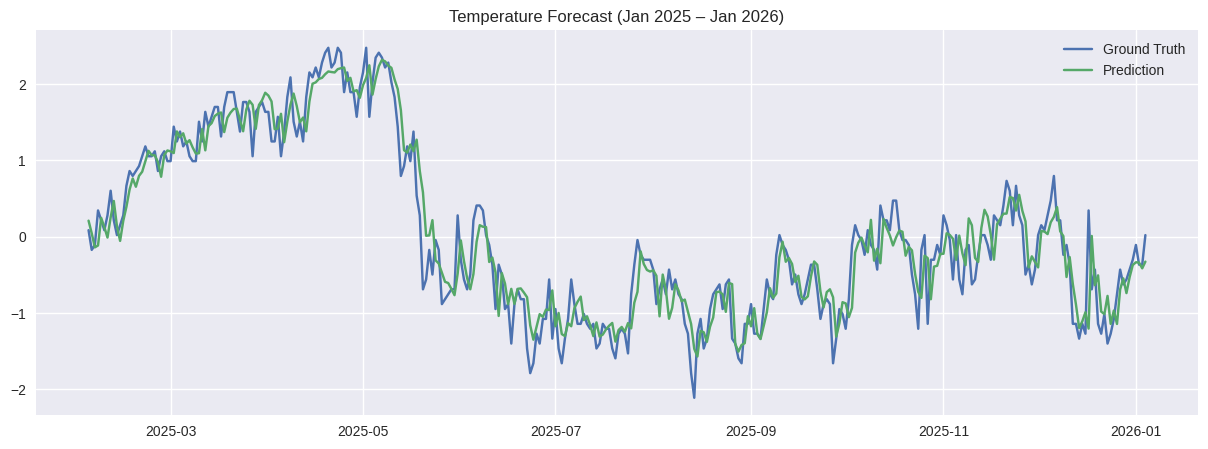

In [38]:
import matplotlib.pyplot as plt

dates = test_df.index[WINDOW:]

plt.figure(figsize=(15,5))
plt.plot(dates, y_test, label="Ground Truth")
plt.plot(dates, preds, label="Prediction")
plt.title("Temperature Forecast (Jan 2025 – Jan 2026)")
plt.legend()
plt.show()


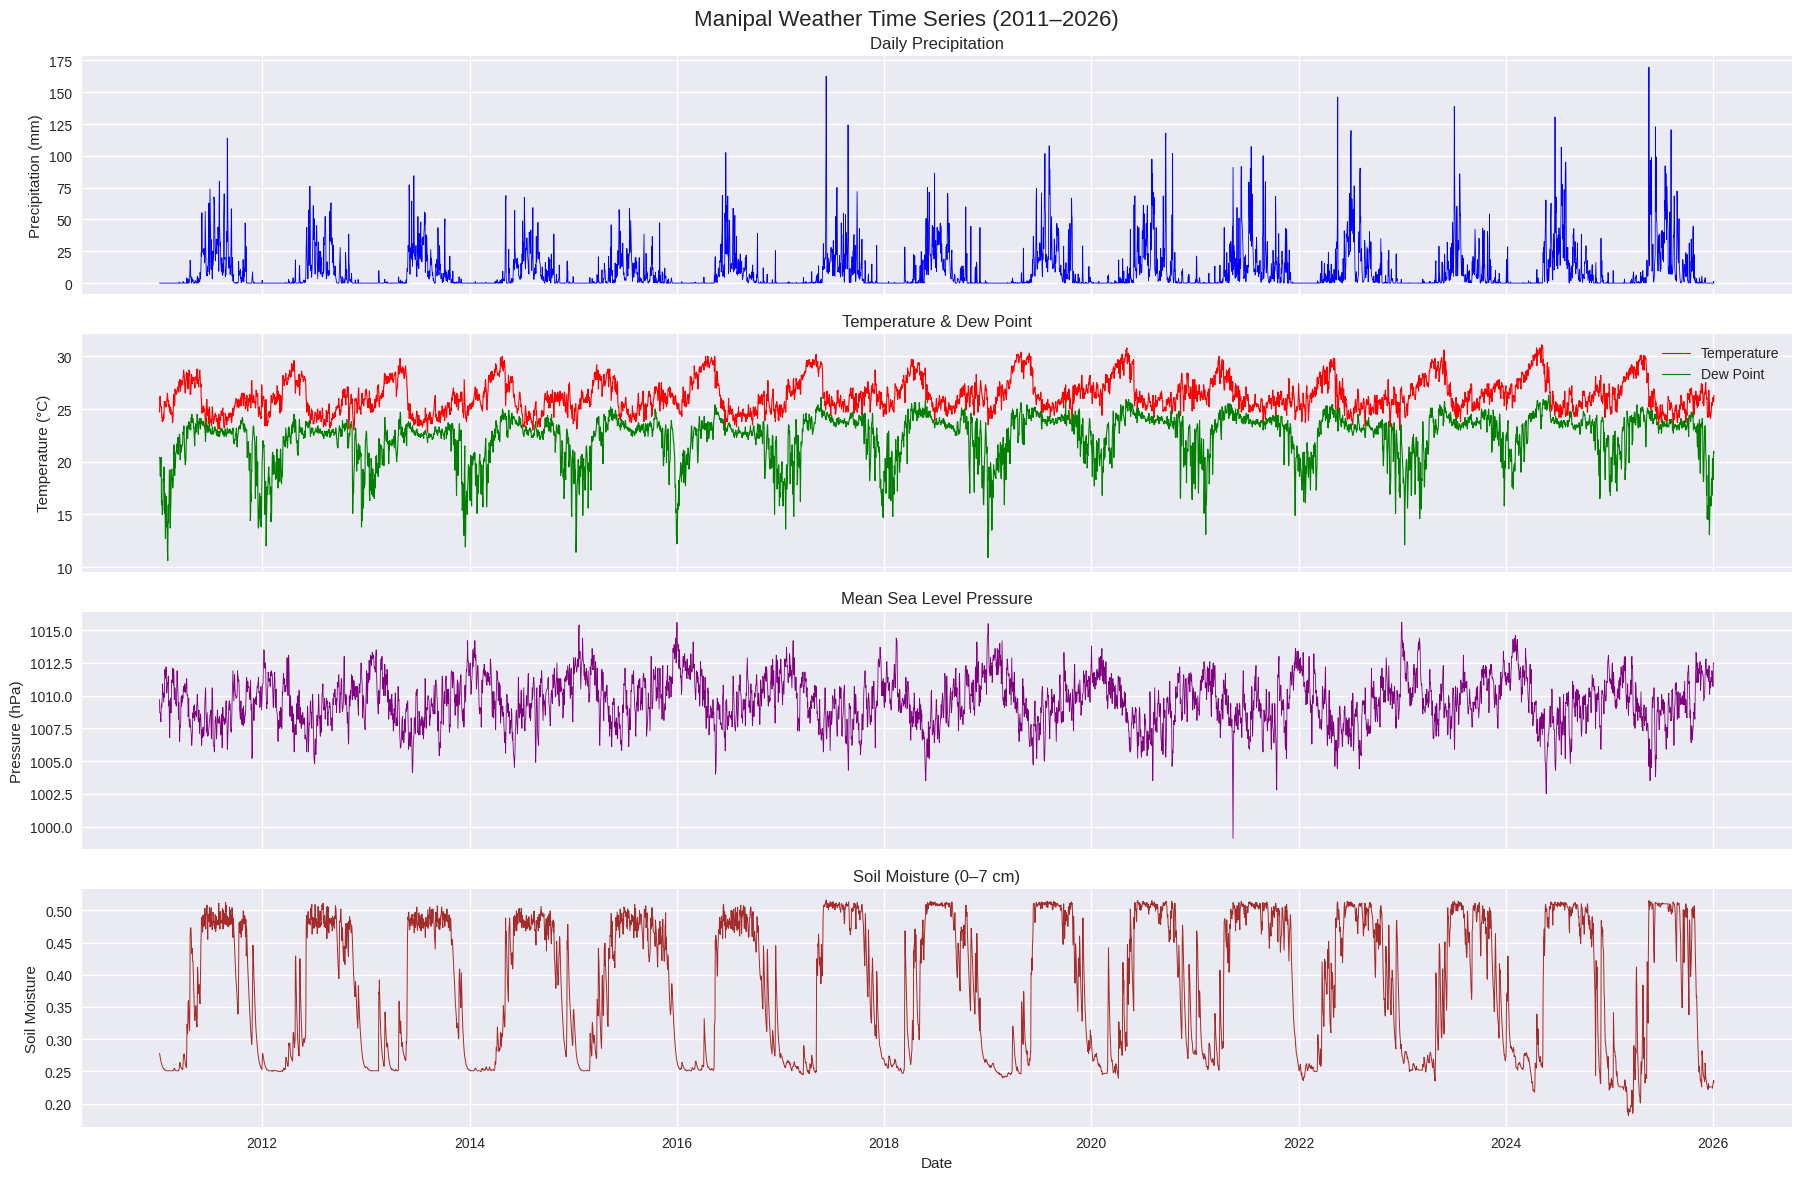

In [48]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)


axes[0].plot(df.index, df['precipitation_sum'], color='blue', linewidth=0.6)
axes[0].set_title("Daily Precipitation")
axes[0].set_ylabel("Precipitation (mm)")




axes[1].plot(df.index, df['temperature_2m_mean'], color='red', label='Temperature', linewidth=0.8)
axes[1].plot(df.index, df['dew_point_2m_mean'], color='green', label='Dew Point', linewidth=0.8)
axes[1].set_title("Temperature & Dew Point")
axes[1].set_ylabel("Temperature (°C)")
axes[1].legend()



axes[2].plot(df.index, df['pressure_msl_mean'], color='purple', linewidth=0.6)
axes[2].set_title("Mean Sea Level Pressure")
axes[2].set_ylabel("Pressure (hPa)")



axes[3].plot(df.index, df['soil_moisture_0_to_1cm'], color='brown', linewidth=0.7)
axes[3].set_title("Soil Moisture (0–7 cm)")
axes[3].set_ylabel("Soil Moisture")
axes[3].set_xlabel("Date")

plt.suptitle("Manipal Weather Time Series (2011–2026)", fontsize=16)
plt.tight_layout()
plt.show()